# Time Series - Parametric fit example

###### Covid-19 dataset (Johns Hopkins University)  https://github.com/CSSEGISandData/COVID-19

###### Article on this use case

### 0 - Setup

###### Import pckgs 

In [6]:
from ts_utils import *
import warnings
warnings.filterwarnings("ignore")

###### Import data

In [2]:
dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,201,230,264,302,367,409,454,511,584,716
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7


###### I'll select 1 country (ex. Italy) and look at 2 time series: 
- total cases per day
- daily changes, i.e. new cases distribution

In [3]:
## groupby country
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["Italy"].values, columns=["total"])

## create daily changes column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')

In [4]:
dtf.head()

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0


In [5]:
dtf.tail()

,total,new
2020-03-27,86498,5909.0
2020-03-28,92472,5974.0
2020-03-29,97689,5217.0
2020-03-30,101739,4050.0
2020-03-31,105792,4053.0


### 1 - TimeSeries Analysis (cumulated cases)

###### I have to find the best curve to fit the data:
- y = f(x)
- x = t

###### Total cases

In [7]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 1500*x

y_linear = f(x=np.arange(len(dtf)))

In [8]:
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 10 + 1.18**x

y_exponential = f(x=np.arange(len(dtf)))

In [9]:
'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 90000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(dtf)))

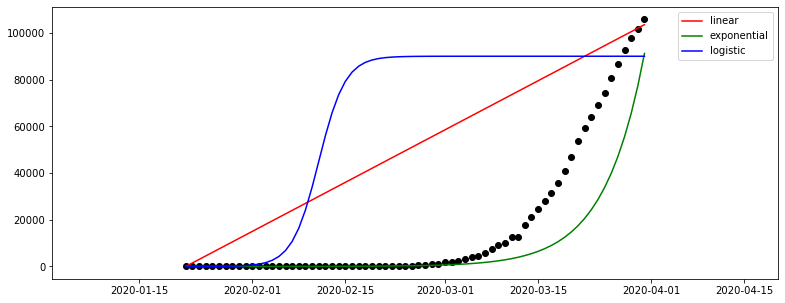

In [10]:
fig, ax = plt.subplots(figsize=(13,5))
ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ax.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
ax.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.legend()
plt.show()

In [11]:
#-> Data starts low and grows exponentially ... looks similar to a exponential function. But I know for fact that
#   this phenomenon has an upper limit, because the virus can't infect more than the total population of the country.
#   Therefore the logistic function is more appropriate to model this data.

###### New cases

In [12]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(x):
    return 6000 * np.exp(-0.5 * ((x-60)/6)**2)

y_gaussian = f(x=np.arange(len(dtf)))

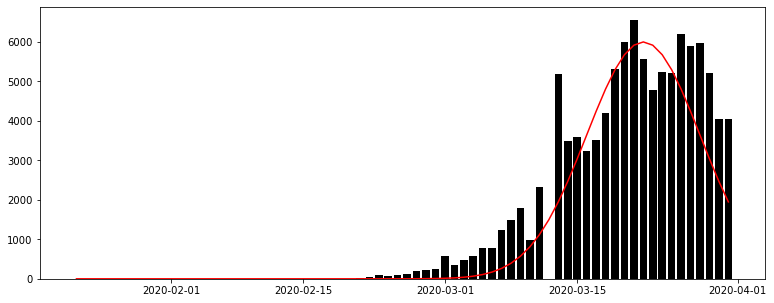

In [15]:
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(dtf["new"].index, dtf["new"].values, color="black")
ax.plot(dtf["new"].index, y_gaussian, color="red")
plt.show()

### 2 - Model Desing & Testing

###### Total cases

In [16]:
'''
Function to fit. In this case logistic function:
    f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

In [17]:
## Fit
model = fit_curve(X=np.arange(len(dtf["total"])), y=dtf["total"].values, f=f, p0=[np.max(dtf["total"]), 1, 1])
model

array([1.29749197e+05, 1.85361042e-01, 6.11355473e+01])

--- generating index date --> start: 2020-04-01 00:00:00 | end: 2020-04-29 00:00:00 | len: 29 ---


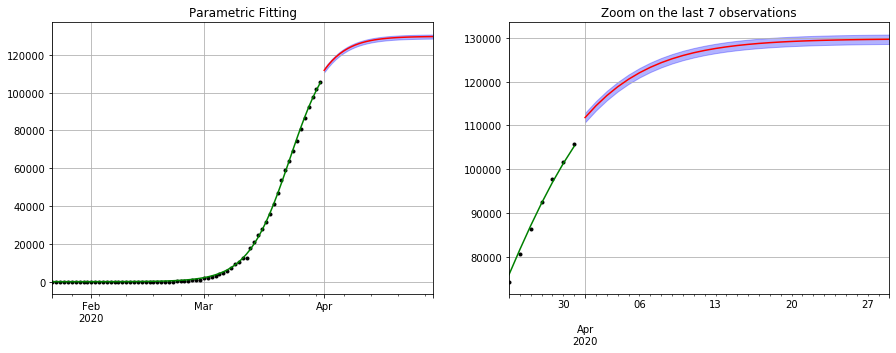

In [20]:
## Forecast
preds = forecast_curve(dtf["total"], f, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

###### New cases

In [21]:
'''
Function to fit. In this case gaussian function:
    f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y

In [22]:
model = fit_curve(X=np.arange(len(dtf["new"])), y=dtf["new"].values, f=f, p0=[1, np.mean(dtf["new"]), np.std(dtf["new"])])
model

array([5790.32039854,   62.04015733,    9.09836419])

--- generating index date --> start: 2020-04-01 00:00:00 | end: 2020-04-29 00:00:00 | len: 29 ---


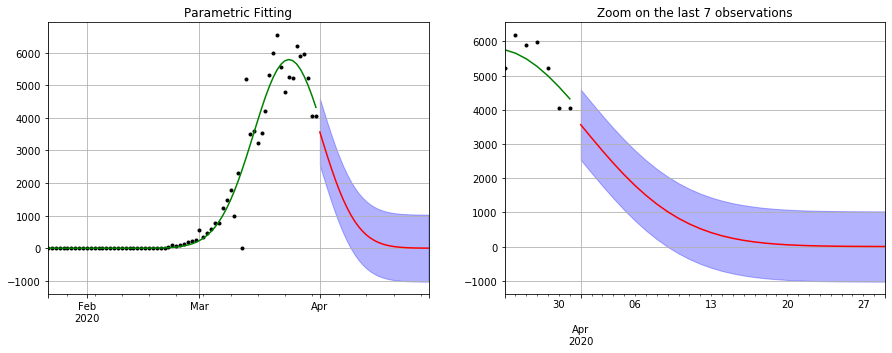

In [23]:
## Forecast
preds = forecast_curve(dtf["new"], f, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))